# 01: 次元削減 - 線形変換の基礎

このノートブックでは、高次元のデータを低次元空間に写像することで、データの可視化、ノイズ除去、計算効率の向上などを実現する「次元削減」の基礎について学びます。
特に、線形変換に基づく代表的な手法である**主成分分析 (PCA)**と**線形判別分析 (LDA)**、そしてPCAを大規模データやストリームデータに適用するための**Incremental PCA**に焦点を当てます。

これらの手法は、それぞれ異なる目的（分散の最大化 vs クラス分離の最大化）に基づいて、最適な低次元空間への射影軸を見つけ出します。

**参考論文:**
*   (PCA) Pearson, K. (1901). On lines and planes of closest fit to systems of points in space. *Philosophical Magazine*, 2(11), 559-572.
*   (LDA) Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. *Annals of Eugenics*, 7(2), 179-188.
*   (Incremental PCA) Ross, D. A., Lim, J., Lin, R. S., & Yang, M. H. (2008). Incremental learning for robust visual tracking. *International journal of computer vision*, 77(1), 125-141.

**このノートブックで学ぶこと:**
1.  次元削減の目的と、教師なし手法（PCA）と教師あり手法（LDA）の違い。
2.  PCAの理論：分散を最大化する方向（主成分）を見つける。共分散行列の固有値分解との関係。
3.  NumPyを用いたPCAのスクラッチ実装。
4.  大規模データに対応するためのIncremental PCAの考え方と実装。
5.  LDAの理論：クラス内分散を小さく、クラス間分散を大きくする射影軸を見つける。
6.  NumPyを用いたLDAのスクラッチ実装と、PCAとの結果の比較。

**前提知識:**
*   線形代数の基礎（ベクトル、行列、転置、行列積）。
*   固有値と固有ベクトルの概念。
*   統計学の基礎（平均、分散、共分散）。
*   NumPyによるベクトル・行列演算。

## 1. 必要なライブラリのインポート

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

## 2. 主成分分析 (Principal Component Analysis, PCA)

PCAは、**教師なし**次元削減手法の代表格です。その目的は、データが最も「散らばっている」方向、すなわち**分散が最大になる方向**を見つけ出し、その方向を新しい軸（主成分）とすることです。データをこの主成分軸に射影することで、元の情報量をできるだけ維持したまま次元を削減します。

### 2.1 PCAの理論

$N$個のデータポイント $\{\boldsymbol{x}_1, \dots, \boldsymbol{x}_N\}$（各$\boldsymbol{x}_i \in \mathbb{R}^D$）からなるデータセット $X$ があるとします。

1.  **データ中心化**: まず、データの中心を原点に移動させます。
    $$ \boldsymbol{x}'_i = \boldsymbol{x}_i - \boldsymbol{\bar{x}} \quad (\text{where } \boldsymbol{\bar{x}} = \frac{1}{N}\sum_i \boldsymbol{x}_i) $$

2.  **共分散行列の計算**: 中心化されたデータの共分散行列 $S$ を計算します。
    $$ S = \frac{1}{N} \sum_{i=1}^N \boldsymbol{x}'_i (\boldsymbol{x}'_i)^T = \frac{1}{N} X' (X')^T $$

3.  **固有値分解**: 共分散行列 $S$ を固有値分解します。
    $$ S\boldsymbol{v} = \lambda\boldsymbol{v} $$
    ここで、$\lambda$ は固有値、$\boldsymbol{v}$ は対応する固有ベクトルです。

この固有ベクトル $\boldsymbol{v}$ が、データの分散が大きい方向、すなわち**主成分**を表します。固有値 $\lambda$ は、その主成分方向の分散の大きさに対応します。

4.  **次元削減**: データを $d$次元（$d < D$）に削減するには、**大きい方から $d$ 個の固有値に対応する固有ベクトル**（主成分）を選び出し、それらを列として並べた射影行列 $W = [\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_d]$ を作ります。
    中心化されたデータをこの射影行列に射影することで、次元削減された新しいデータ $Z$ が得られます。

### 2.2 PCAのスクラッチ実装

#### 2.2.1 データの準備

有名なアヤメ（Iris）データセットを使います。このデータセットは4次元ですが、可視化のために2次元に削減します。

In [23]:
# Irisデータセットのロード
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

#### 2.2.2 PCAクラスの実装

In [24]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None

    def fit(self, x):
        # データの中心化
        self.mean_ = np.mean(x, axis=0)
        x_centered = x - self.mean_

        # 共分散行列の計算
        S = np.cov(x_centered, rowvar=False)

        # 固有値と固有ベクトルの計算
        eigenvalues, eigenvectors = np.linalg.eigh(S)

        # 固有値の降順でソートし，対応する固有ベクトルもソート
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.components_ = eigenvectors[:, sorted_indices]

        return self
    
    def transform(self, x):
        # データの中心化 
        x_centered = x - self.mean_

        # 上位k個の主成分を洗濯
        projection_matrix = self.components_[:, :self.n_components]

        # データを射影
        x_pca = np.dot(x_centered, projection_matrix)

        return x_pca

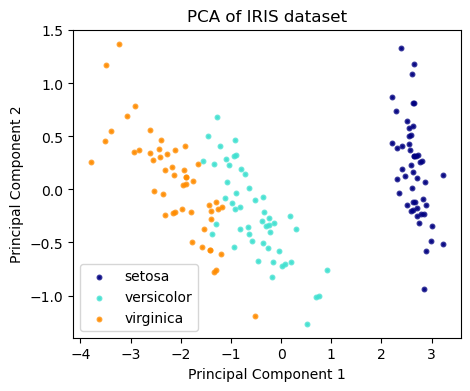

In [25]:
# PCAを実行して2次元に削減
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# 結果をプロット
plt.figure(figsize=(5, 4))
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=.8, lw=2,
                label=target_name, s=5)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 3. Incremental PCA

PCAは共分散行列の計算が必要なため、データセット全体をメモリに読み込む必要があります。これは、データが非常に大きい場合や、次々と新しいデータがやってくるストリームデータの場合には適用できません。

**Incremental PCA (IPCA)** は、データを一度に全て見るのではなく、ミニバッチ単位で少しずつ処理し、主成分を逐次的に更新していく手法です。これにより、メモリ使用量を大幅に削減できます。


### 3.1 IPCAの理論

Ross et al. (2008) の論文で提案された手法は、特異値分解（SVD）を逐次的に更新するアルゴリズムに基づいています。ここではその厳密な数式は省略しますが、中心的なアイデアは以下の通りです。

1.  最初のミニバッチでPCA（またはSVD）を実行し、初期の主成分と平均を計算する。
2.  新しいミニバッチが来たら、既存の主成分と新しいデータの情報を組み合わせて、更新された主成分と平均を計算する。この際、過去の情報を要約した行列と新しいデータのみで計算が行われるため、過去の全データを保持する必要がない。
3.  オプションとして「忘却係数（forgetting factor）」を導入し、古いデータの影響を徐々に減らしながら、最近のデータの傾向により適応させることも可能。

### 3.2 IPCAクラスの実装（簡易版）

完全なIPCAの実装は複雑なため、ここではそのコンセプトを示す簡易版を実装します。データ全体の平均を事前に計算し、共分散行列をミニバッチ単位で逐次的に計算していく方法です。

In [26]:
class IncrementalPCA:
    def __init__(self, n_components, batch_size=10):
        self.n_components = n_components
        self.batch_size = batch_size
        self.components_ = None
        self.mean_ = None
        self.n_samples_seen_ = 0

    def fit(self, X):
        n_samples, n_features = X.shape
        # データ全体の平均を先に計算（厳密なオンライン学習ではこれも逐次更新する）
        self.mean_ = np.mean(X, axis=0)
        
        # 共分散行列を初期化
        cov_matrix = np.zeros((n_features, n_features))
        
        for i in range(0, n_samples, self.batch_size):
            batch = X[i:i+self.batch_size]
            batch_centered = batch - self.mean_
            
            # ミニバッチの共分散行列を計算し、加算していく
            cov_matrix += batch_centered.T @ batch_centered
            self.n_samples_seen_ += len(batch)

        # 最終的な共分散行列
        cov_matrix /= (self.n_samples_seen_ -1)

        # 固有値分解
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.components_ = eigenvectors[:, sorted_indices]
        
        return self

    def transform(self, X):
        # transformは通常のPCAと同じ
        X_centered = X - self.mean_
        projection_matrix = self.components_[:, :self.n_components]
        return X_centered @ projection_matrix

In [27]:
# Incremental PCAを実行
ipca = IncrementalPCA(n_components=2, batch_size=50)
ipca.fit(X)
X_ipca = ipca.transform(X)

# 結果が通常のPCAとほぼ同じになることを確認
print("PCAとIncremental PCAの主成分の差（ノルム）:", np.linalg.norm(np.abs(pca.components_) - np.abs(ipca.components_)))

PCAとIncremental PCAの主成分の差（ノルム）: 9.518179688573629e-15


## 4. 線形判別分析 (Linear Discriminant Analysis, LDA)

LDAは、PCAとは異なり、**教師あり**の次元削減手法です。PCAがデータの分散を最大化しようとするのに対し、LDAは**クラスを最もよく分離する方向**を見つけ出すことを目的とします。

### 4.1 LDAの理論

LDAは、射影後のデータが以下の2つの条件を満たすような射影軸を見つけようとします。

1.  **クラス間分散 (Between-class variance) が最大になる**: 異なるクラスの中心（平均）ができるだけ遠くに離れる。
2.  **クラス内分散 (Within-class variance) が最小になる**: 同じクラス内のデータができるだけ密集する。

具体的には、以下の手順で計算されます。

1.  **クラス内散布行列 (Within-class scatter matrix) $S_W$ の計算**:
    各クラスの共分散行列を計算し、それらを全て足し合わせます。
    $$ S_W = \sum_{k=1}^{C} S_k = \sum_{k=1}^{C} \sum_{\boldsymbol{x}_i \in C_k} (\boldsymbol{x}_i - \boldsymbol{\mu}_k)(\boldsymbol{x}_i - \boldsymbol{\mu}_k)^T $$
    ここで、$C$はクラス数、$\boldsymbol{\mu}_k$はクラス$k$の平均ベクトルです。

2.  **クラス間散布行列 (Between-class scatter matrix) $S_B$ の計算**:
    各クラスの平均ベクトルとデータ全体の平均ベクトルとの差を計算し、行列を構築します。
    $$ S_B = \sum_{k=1}^{C} N_k (\boldsymbol{\mu}_k - \boldsymbol{\mu})(\boldsymbol{\mu}_k - \boldsymbol{\mu})^T $$
    ここで、$N_k$はクラス$k$のサンプル数、$\boldsymbol{\mu}$はデータ全体の平均ベクトルです。

3.  **一般化固有値問題の求解**:
    LDAは、比率 $\frac{\text{tr}(W^T S_B W)}{\text{tr}(W^T S_W W)}$ を最大化する射影行列 $W$ を見つける問題に帰着します。これは、以下の**一般化固有値問題**を解くことと等価です。
    $$ S_B \boldsymbol{v} = \lambda S_W \boldsymbol{v} \quad \iff \quad (S_W^{-1} S_B) \boldsymbol{v} = \lambda \boldsymbol{v} $$
    この固有ベクトル $\boldsymbol{v}$ が、クラスを最もよく分離する射影軸となります。

4.  **次元削減**:
    大きい方から $d$ 個の固有値に対応する固有ベクトルを選び、射影行列 $W$ を作ってデータを射影します。LDAで得られる射影軸の最大数は $C-1$ となります。

In [ ]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # クラス内散布行列 S_W の計算
        S_W = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # 各クラスの共分散行列 * (サンプル数 - 1)
            S_W += (X_c - mean_c).T @ (X_c - mean_c)
            
        # クラス間散布行列 S_B の計算
        mean_overall = np.mean(X, axis=0)
        S_B = np.zeros((n_features, n_features))
        for c in class_labels:
            n_c = X[y == c].shape[0]
            mean_c = np.mean(X[y == c], axis=0)
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            S_B += n_c * (mean_diff @ mean_diff.T)
            
        # 一般化固有値問題の求解
        # S_Wが特異行列になるのを避けるため、正則化項を加えることもあります
        A = np.linalg.inv(S_W) @ S_B
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        
        # 固有値を降順にソートし、対応する固有ベクトルも並べ替える
        sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
        self.components_ = eigenvectors[:, sorted_indices]
        
        return self

    def transform(self, X):
        projection_matrix = self.components_[:, :self.n_components]
        return X @ projection_matrix

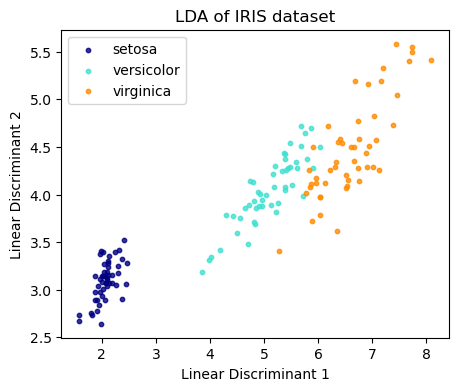

In [30]:
# LDAを実行して2次元に削減
# Irisは3クラスなので、最大2次元に削減可能
lda = LDA(n_components=2)
lda.fit(X, y)
X_lda = lda.transform(X)

# 結果をプロット
plt.figure(figsize=(5, 4))
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color,
                label=target_name, s=10)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.show()

## 5. まとめと考察

このノートブックでは、次元削減のための主要な線形変換手法であるPCA、Incremental PCA、そしてLDAについて学び、実装しました。

*   **PCA**は、**教師なし**の手法で、データの**分散が最大**になる方向（主成分）を見つけ出します。データの全体的な構造を保持したまま次元を削減するのに適しています。
*   **Incremental PCA**は、PCAを大規模データやストリームデータに適用可能にするための手法で、データをミニバッチで処理することでメモリ効率を高めます。
*   **LDA**は、**教師あり**の手法で、**クラスの分離が最大**になる方向を見つけ出します。分類タスクの前処理として、クラスを識別するのに重要な特徴量を抽出する目的で使われます。

Irisデータセットの例では、LDAがPCAよりも明確に3つのクラスを分離していることがわかります。これは、LDAがクラスラベルの情報を利用して、クラス間の違いが最も顕著になるように射影軸を学習したためです。

どちらの手法が優れているというわけではなく、**目的によって使い分ける**ことが重要です。データの可視化や圧縮が目的ならPCA、分類性能の向上が目的ならLDAが、それぞれ強力なツールとなります。